In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
import pandas as pd
from sklearn import metrics
from scipy.spatial.distance import cdist
import imageio

from lib.file.ROI_reader import ROIFileReader
from lib.analysis.laminar_dist import LaminarROI
from lib.analysis.align import ImageAlign
from lib.utilities import *
# implementation of single-cell identification as outlined in 
# https://www.proquest.com/docview/2838882181?pq-origsite=gscholar&fromopenview=true&sourcetype=Dissertations%20&%20Theses
# and implemented in R/Python here: https://github.com/ksscheuer/ROI_Identification
# https://github.com/ksscheuer/Single_Cell_Identification/blob/main/AutomaticallyChooseROIs_part1.R


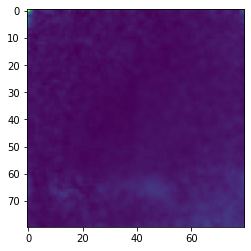

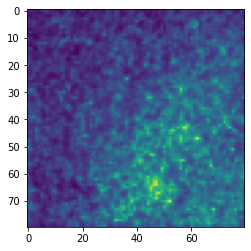

In [4]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/pv-cre-mCherry/02-20-24/zda/"
target_recording = '02_01_04'
tdTomato_rois = data_dir + 'ROIs-red' + target_recording + '.dat'
# input files: *_amp.dat, *_snr.dat   # do not normalize!
cluster_SNRcutoff = 1
k_choice = 6  # none is auto

ROI_px_cutoff = 9
SNR_cutoff = 2.5
Amp_cutoff = 1

data = {}
for fn in ['_amp.dat', '_snr.dat']:
    fn2 = data_dir + target_recording + fn
    data_arr = pd.read_csv(fn2,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    data_arr = np.array(data_arr['Values']).reshape((80, 80))
    plt.imshow(data_arr)
    plt.show()
    data[fn] = data_arr

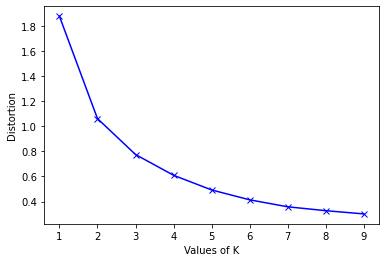

In [5]:
# elbow plot
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = data['_snr.dat'].reshape((-1,1))

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.show()

[[5 0 0 ... 0 5 5]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 5 5 0]
 ...
 [2 5 5 ... 2 2 5]
 [5 5 5 ... 1 2 5]
 [0 0 0 ... 2 5 2]]


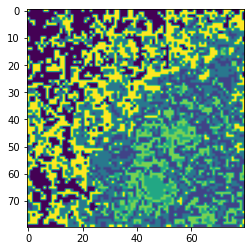

In [6]:
# Step1 produce: Density plot of SNR for all pixels,
#         K-means clustering plot of heatmap with cutoff applied
# Step2 produce: remove ROIs with diameters > cutoff

# K-means cluster on SNR data
km = KMeans(n_clusters=k_choice)
km.fit(data['_snr.dat'].reshape((-1,1)))
labels = km.predict(data['_snr.dat'].reshape((-1,1)))
labels = labels.reshape((80,80))
plt.imshow(labels)
print(labels)
plt.show()

[[2.6015   2.0485   1.85003  ... 1.16783  3.31435  2.88781 ]
 [1.57538  1.44302  1.77359  ... 1.78771  3.4967   2.50453 ]
 [0.844184 1.00669  1.87183  ... 3.71668  2.66458  1.77117 ]
 ...
 [4.33899  3.90664  2.76664  ... 5.23068  4.42083  3.78358 ]
 [3.19612  3.30176  2.61026  ... 6.83029  4.36615  3.79376 ]
 [2.54154  2.52332  2.3495   ... 5.4234   3.86427  4.78953 ]]
[[2.6015   2.0485   1.85003  ... 1.16783  3.31435  2.88781 ]
 [1.57538  1.44302  1.77359  ... 1.78771  3.4967   2.50453 ]
 [0.844184 1.00669  1.87183  ... 3.71668  2.66458  1.77117 ]
 ...
 [4.33899  3.90664  2.76664  ... 5.23068  4.42083  3.78358 ]
 [3.19612  3.30176  2.61026  ... 6.83029  4.36615  3.79376 ]
 [2.54154  2.52332  2.3495   ... 5.4234   3.86427  4.78953 ]]
[[2.6015   2.0485   1.85003  ... 1.16783  3.31435  2.88781 ]
 [1.57538  1.44302  1.77359  ... 1.78771  3.4967   2.50453 ]
 [0.844184 1.00669  1.87183  ... 3.71668  2.66458  1.77117 ]
 ...
 [4.33899  3.90664  2.76664  ... 5.23068  4.42083  3.78358 ]
 [3.196

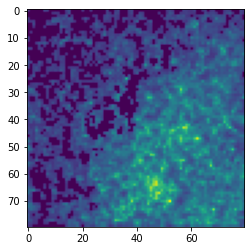

In [7]:
def get_cluster_value(k, labels, values):
    print(values)
    n, m = labels.shape
    ls = []
    for i in range(n):
        for j in range(m):
            if k == labels[i][j]:
                ls.append(values[i][j])
    return np.mean(ls)
                
snr = data['_snr.dat']
amp = data['_amp.dat']
cluster_snrs = [get_cluster_value(k, labels, data['_snr.dat']) for k in range(k_choice)]
for i in range(len(cluster_snrs)):
    if cluster_snrs[i] < cluster_SNRcutoff:
        print("remove cluster", i, "cluster SNR:", cluster_snrs[i])
        snr[labels == i] = 0

snr[snr < SNR_cutoff] = 0
snr[amp < Amp_cutoff] = 0
plt.imshow(snr)

In [ ]:
# pixel size cutoffs

def get_ROI(i, j, snr, visited):
    """ marks all contiguous pixels visited in the process """
    n, m = snr.shape
    visited[i][j] = 1
    if snr[i][j] == 0:
        return []
    roi = [[i, j]]
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            ii = i + dx 
            jj = j + dy
            if 0 <= ii < n and 0 <= jj < m and visited[ii][jj] == 0:
                roi +=  get_ROI(ii, jj, snr, visited)
    return roi
    
n, m = snr.shape
visited = np.zeros((n, m))
survivors = []
for i in range(n):
    for j in range(m):
        if visited[i][j] == 0:
            roi = get_ROI(i, j, snr, visited)
            if 0 < len(roi) < ROI_px_cutoff:
                survivors.append(roi)
print([len(s) for s in survivors])
kkm_roi_map = np.zeros((n, m))
for roi in survivors:
    for px in roi:
        i, j = px
        kkm_roi_map[i][j] = 1
        
plt.imshow(kkm_roi_map)
plt.show()
print(np.sum(kkm_roi_map))

: 

In [1]:
# read in red labels 
rfr = ROIFileReader(tdTomato_rois)
red_rois = rfr.get_roi_list()

print(red_rois, len(red_rois))
red_rois = [LaminarROI(rr).get_points() for rr in red_rois]
print(red_rois, len(red_rois))
red_roi_map = np.zeros((n, m))
for roi in red_rois:
    for px in roi:
        i, j = px
        red_roi_map[j][i] = 1
plt.imshow(red_roi_map)
plt.show()
print(np.sum(red_roi_map))

NameError: name 'ROIFileReader' is not defined

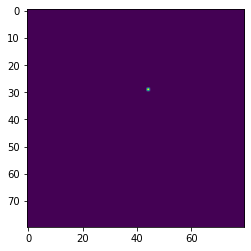

1


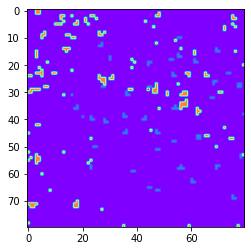

In [ ]:
# overlap of red_roi_map and kkm_roi_map
overlap_map = np.logical_and(red_roi_map, kkm_roi_map)
plt.imshow(overlap_map)
plt.show()
print(np.sum(overlap_map))

superpose_map = red_roi_map + kkm_roi_map*5
plt.imshow(superpose_map, cmap='rainbow')